# Problem 9
The integral $$I(\alpha) = \int_0^2 (2 + \sin(10\alpha)) \; x^\alpha \sin(\frac{\alpha}{2-x}) dx $$ depends on the parameter $\alpha$. What is the value of $\alpha$ in $[0,5]$ in which $I(\alpha)$ achieves its maximum?

# Builtin Routines

As a baseline, we use builtins from `scipy` to attempt to maximize the above integral

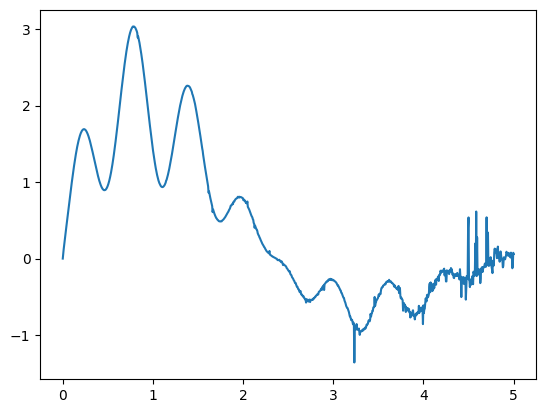

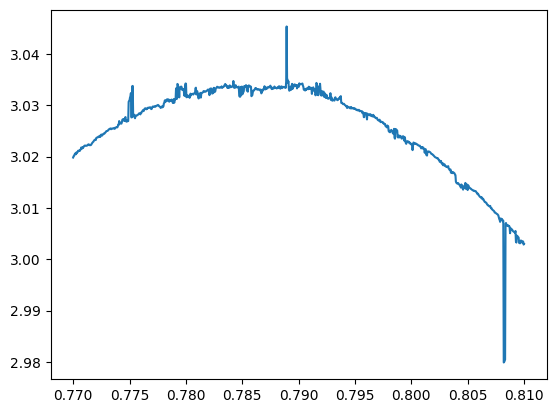

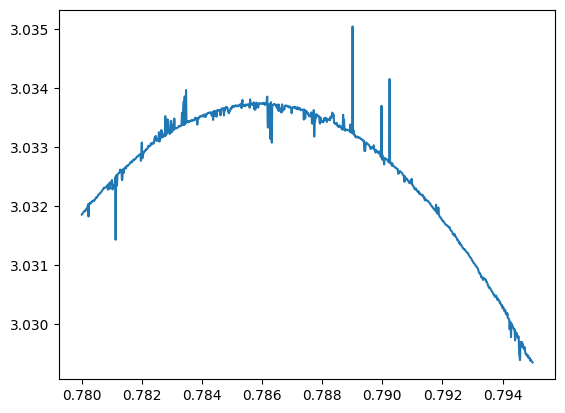

<Figure size 640x480 with 0 Axes>

In [23]:
import warnings

from scipy.integrate import quad
from math import sin
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def I(a, eps, limit):
    out, _ = quad(lambda x: (2+sin(10*a))*x**a*sin(a/(2-x)), 0, 2, epsabs=eps, epsrel=eps, limit=limit)
    return out

# To suppress IntegrationWarning warning about maximum subdivisions reached
with warnings.catch_warnings():
    for x, eps, limit in zip([np.linspace(0,5,1000), np.linspace(0.77,0.81,1000), np.linspace(0.78,0.795,1000)], 
                             [1e-5, 1e-5, 1e-12],
                             [50, 100, 1000]):
        plt.plot(x, np.vectorize(lambda x: I(x, eps=eps, limit=limit))(x))
        plt.show()
        plt.clf()

From initial findings, we see that we attain a maximum of $I(\alpha) \approx 3.033 $ where $\alpha \approx 0.786 $ 

We now attempt to use out-of-the-box maximization routines that the `scipy` module provides on the integral.

In [26]:
from scipy.optimize import minimize_scalar

def I(a):
    out, _ = quad(lambda x: (2+sin(10*a))*x**a*sin(a/(2-x)), 0, 2, epsabs=1e-15, epsrel=1e-15, limit=100000)
    return -out

%time minimize_scalar(I)

CPU times: user 2min 11s, sys: 24.9 ms, total: 2min 11s
Wall time: 2min 11s


     fun: -3.033733163355978
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 28
     nit: 24
 success: True
       x: 0.7859422948318388

In [27]:
a = 0.7859422948318388
quad(lambda x: (2+sin(10*a))*x**a*sin(a/(2-x)), 0, 2, epsabs=1e-15, epsrel=1e-15, limit=100000)

(3.033733163355978, 2.564722480374352e-06)

Note that when calculating the integral with the above parameters, we have an error of $\approx 10^{-6}$ - it stands to reason that only 6 of the digits we have for our maximum can be accurate - it turns out that only 4 of them are.

# Attempt 2: Manipulating the Integral
We have that $$ I(\alpha) = \underbrace{(2+\sin(10\alpha))}_{:=f(\alpha)} \underbrace{\int_0^2 x^a \sin(\frac{\alpha}{2-x}) dx}_{:=I_1(\alpha)}$$

Note that by substituting $u = \frac{1}{2-x}, du = \frac{1}{u^2}$, we can rewrite $$I_1(\alpha) = \int_{1/2}^\infty \frac{(2-1/u)^\alpha}{u^2} \sin(\alpha u) du$$.

We use adaptive integration - i.e. we integrate between the zeros of the integrand until we achieve the desired error. This is done with the builtin [`quadosc`](https://mpmath.org/doc/current/calculus/integration.html#oscillatory-quadrature-quadosc) function in the `mpmath` module

In [122]:
import mpmath
from mpmath import quadosc, findroot, diff

mpmath.mp.dps = 20

def integrand_f(a):
    return lambda u: (2-1/u)**a / (u*u) * mpmath.sin(a*u)

def I(a):
    return (2 + mpmath.sin(10*a)) * quadosc(integrand_f(a), 
                                            [1/2, mpmath.inf], 
                                            zeros = lambda n: 0.5 if n == 0 else n*mpmath.pi/a)
findroot(lambda a: diff(I, a), 0.7)

mpf('0.78593367378800233421807')

With this, we are able to get 8 accurate digits.

# Analytically Solving the Integral

Instead of solving the integral numerically, we attempt to solve it analytically:

We have that 

$$ \begin{align} 
I(\alpha) &= \left(2+\sin{(10 \alpha)} \right) \int_0^2 x^\alpha \sin{\left(\frac{\alpha}{2-x}\right)} dx\\
&= \underbrace{\left(2+\sin{(10 \alpha)} \right)}_{f(\alpha)} \underbrace{\int_0^2 (2-x)^\alpha \sin(\alpha/x) dx}_{I_1(\alpha)} & (x \mapsto 2-x)
\end{align}$$ 

Using the `sympy` module,  we try to integrate directly by representing $I_1$ with the [Meijer G-function](https://en.wikipedia.org/wiki/Meijer_G-function):


In [138]:
from sympy.integrals import meijerint
from sympy.abc import x, alpha
import sympy as sp

from IPython.display import display

_ = [display(i) for i in meijerint.meijerint_definite((2-x)**alpha*sp.sin(alpha/x), x, 0,2)]

sqrt(pi)*alpha*meijerg(((), (alpha/2 + 1/2, alpha/2 + 1)), ((0, 0, 1/2), (-1/2,)), polar_lift(alpha)**2/16)*gamma(alpha + 1)/4

(re(alpha) > -1) & Eq(Abs(arg(alpha)), 0)

We therefore have a closed-form solution for $I$:

$$I(\alpha) = \frac{\sqrt{\pi} \alpha}{4} \left(\sin{\left (10\alpha \right )} + 2\right) {G_{2, 4}^{3, 0}\left(\begin{matrix}  & \frac{\alpha}{2} + \frac{1}{2}, \frac{\alpha}{2} + 1 \\0, 0, \frac{1}{2} & - \frac{1}{2} \end{matrix} \middle| {\frac{\alpha^2}{16}} \right)} \Gamma{\left(\alpha + 1 \right)} $$

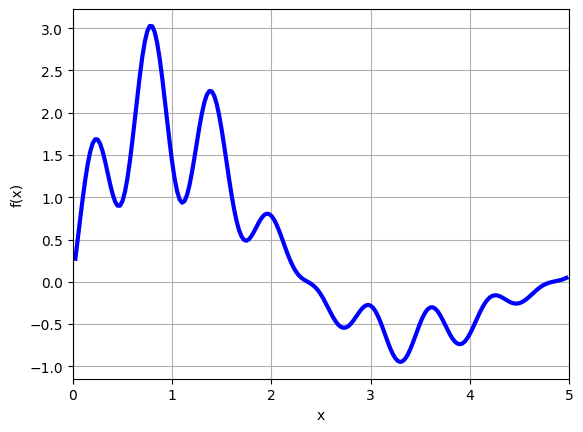

In [144]:
mpmath.mp.dps = 100; mpmath.mp.pretty = True

def I(a):
    return 4*mpmath.sqrt(mpmath.pi)*mpmath.gamma(a)*(2+mpmath.sin(10*a))*mpmath.meijerg([[],[(a+3)/2, (a+4)/2]],[[1,1,1.5],[0.5]],a*a/16)

mpmath.plot(I_1,[0,5])

To find the maximum of this integral, we simply find the root of $I'(\alpha) = 0$ near $\alpha = 0.7$ - with this, we are able to get the answer to 100 digits.

In [155]:
I_prime = lambda x: diff(I,x)
findroot(I_prime, 0.7)

0.7859336743503714545652439863275455829623954590618668175812318070989103971494123651167706337659944953